# Course Project

In this project, we investigate the relation between the average property prices and geometry location factors with in a city. Specifically, we crawl the property price for comunities in Beijing City from [Anjuke](https://beijing.anjuke.com/community), a famous online property trading giant, and combine them with positional information via [Baidu Map API](https://lbsyun.baidu.com/index.php?title=webapi/guide/webservice-geocoding) to re-project them onto OpenStreetMap. We then investigate the influence on property prices from distances towards nearest important social facilities, e.g., school, hospital, metro station, with regression model. The result reveals a strong correlation between important location factors and nearby property price.

In [1]:
import osmnx as ox
import numpy as np
import geopandas as gpd
import pandana
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import networkx as nx

In [2]:
ox.config(log_console=True, use_cache=True)
G = ox.graph_from_place('Beijing', network_type='drive')

D:\ProgramData\Anaconda3\envs\geospatial3\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


### Plotting a road network of OSM object

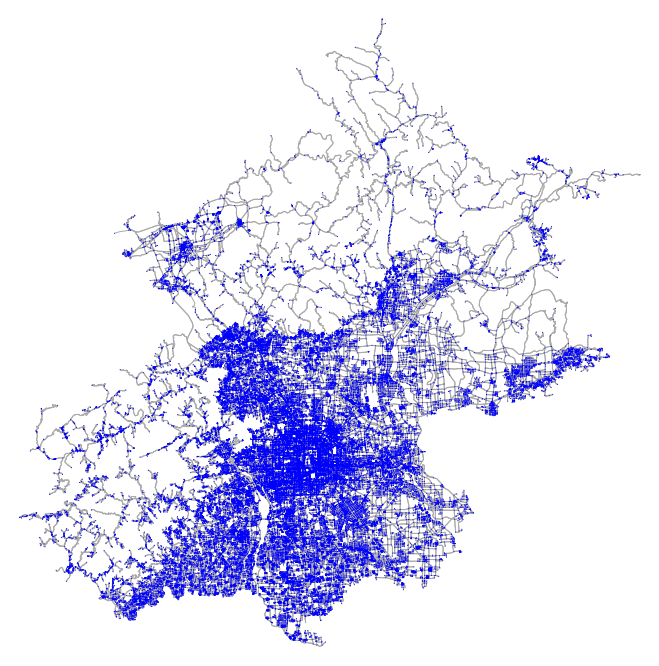

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

In [3]:
ox.plot_graph(G, bgcolor="w", node_size=1, node_color="blue", edge_color="#aaa", figsize=(12,12))

In [4]:
print("node count:", len(G.nodes()))
print("edge count:", len(G.edges()))

node count: 108598
edge count: 267493


In [41]:
ox.config(log_console=True, use_cache=True)

tags = {
    'amenity': ['pharmacy', 'school'],
    'building': ['hospital'],
       }
all_schools = ox.geometries_from_place('Beijing', tags=tags)
print(all_schools.keys())
#we only interested in schools names and it's geometric information
all_schools = all_schools[['name','geometry']]

#filter out empty data
all_schools = all_schools[~(all_schools['name'].isnull())]
all_schools = all_schools[~(all_schools['geometry'].isnull())]

print(all_schools)

2022-05-15 14:20:22 Configured OSMnx 1.1.2
2022-05-15 14:20:22 HTTP response caching is on
2022-05-15 14:20:22 Retrieved response from cache file "cache/17c5f7fabc9b55ff8640592391a53a7511dbb2a0.json"


/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-05-15 14:20:22 Created GeoDataFrame with 1 rows from 1 queries
2022-05-15 14:20:22 Constructed place geometry polygon(s) to query API
2022-05-15 14:20:22 Projected GeoDataFrame to +proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-05-15 14:20:22 Projected GeoDataFrame to epsg:4326
2022-05-15 14:20:22 Requesting data within polygon from API in 16 request(s)
2022-05-15 14:20:22 Resolved overpass-api.de to 178.63.11.215
2022-05-15 14:20:23 Pausing 0 seconds before making HTTP POST request
2022-05-15 14:20:23 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28%28node%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2739.441611+116.428136+39.490088+115.943702+39.842484+115.938322+39.846083+116.459486+39.455365+116.462520+39.447317+116.444117+39.441611+116.428136%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28way%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2739.441611+116.428136+39.490088+115.943702+39.842484+115.938322+39.846083+1

2022-05-15 14:20:32 Downloaded 2.1kB from overpass-api.de
2022-05-15 14:20:32 Saved response to cache file "cache/46abf2ddc7ae65ea95d0e8b28064a9d87564a444.json"
2022-05-15 14:20:32 Resolved overpass-api.de to 178.63.11.215
2022-05-15 14:20:33 Pausing 0 seconds before making HTTP POST request
2022-05-15 14:20:33 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28%28node%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2740.982281+116.450317+41.059364+116.624989+41.059558+116.631693+41.058197+116.641103+41.043713+116.682999+40.907979+116.980408+40.655905+116.980482+40.654611+116.453015+40.982281+116.450317%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28way%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2740.982281+116.450317+41.059364+116.624989+41.059558+116.631693+41.058197+116.641103+41.043713+116.682999+40.907979+116.980408+40.655905+116.980482+40.654611+116.453015+40.982281+116.450317%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28relation%5B%27amenity%27%3D%27pharma

2022-05-15 14:20:42 Downloaded 77.2kB from overpass-api.de
2022-05-15 14:20:42 Saved response to cache file "cache/156ba445ac1c6b5fc978e4ccc777067d839cea05.json"
2022-05-15 14:20:42 Resolved overpass-api.de to 178.63.11.215
2022-05-15 14:20:43 Pausing 0 seconds before making HTTP POST request
2022-05-15 14:20:43 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28%28node%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2740.907979+116.980408+40.672509+117.489575+40.670296+117.493282+40.667849+117.496619+40.659255+117.507985+40.656863+117.507655+40.654793+117.507324+40.655905+116.980482+40.907979+116.980408%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28way%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2740.907979+116.980408+40.672509+117.489575+40.670296+117.493282+40.667849+117.496619+40.659255+117.507985+40.656863+117.507655+40.654793+117.507324+40.655905+116.980482+40.907979+116.980408%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28relation%5B%27amenity%27%3D%27pharm

2022-05-15 14:20:49 Pausing 0 seconds before making HTTP POST request
2022-05-15 14:20:49 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28%28node%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2739.847322+117.067766+39.758557+116.980738+39.847340+116.980713+39.847322+117.067766%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28way%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2739.847322+117.067766+39.758557+116.980738+39.847340+116.980713+39.847322+117.067766%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28relation%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2739.847322+117.067766+39.758557+116.980738+39.847340+116.980713+39.847322+117.067766%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28node%5B%27amenity%27%3D%27school%27%5D%28poly%3A%2739.847322+117.067766+39.758557+116.980738+39.847340+116.980713+39.847322+117.067766%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28way%5B%27amenity%27%3D%27school%27%5D%28poly%3A%2739.847322+117.067766+39.758557+116.980738+39.847340+116.980713+39.847

2022-05-15 14:20:55 Pausing 0 seconds before making HTTP POST request
2022-05-15 14:20:55 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28%28node%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2740.242837+115.572707+40.537221+115.746696+40.650818+115.915942+40.650909+115.925614+40.246711+115.932032+40.242837+115.572707%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28way%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2740.242837+115.572707+40.537221+115.746696+40.650818+115.915942+40.650909+115.925614+40.246711+115.932032+40.242837+115.572707%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28relation%5B%27amenity%27%3D%27pharmacy%27%5D%28poly%3A%2740.242837+115.572707+40.537221+115.746696+40.650818+115.915942+40.650909+115.925614+40.246711+115.932032+40.242837+115.572707%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28node%5B%27amenity%27%3D%27school%27%5D%28poly%3A%2740.242837+115.572707+40.537221+115.746696+40.650818+115.915942+40.650909+115.925614+40.246711+115.932032+40.242837

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


2022-05-15 14:21:00 Identified 2197 geometries inside polygon
2022-05-15 14:21:00 103 geometries removed by the polygon filter
2022-05-15 14:21:00 104 geometries removed by the tag filter
2022-05-15 14:21:00 2094 geometries in the final GeoDataFrame
Index(['amenity', 'name', 'geometry', 'barrier', 'access', 'wheelchair',
       'healthcare', 'dispensing', 'name:en', 'operator', 'nodes', 'name:zh',
       'building', 'website', 'addr:city', 'addr:district', 'addr:postcode',
       'addr:province', 'official_name', 'operator:type', 'old_name',
       'addr:housenumber', 'addr:street', 'start_date', 'phone', 'grades',
       'source', 'alt_name', 'religion', 'wikidata', 'wikipedia:zh', 'brand',
       'brand:en', 'brand:wikidata', 'brand:wikipedia', 'brand:zh',
       'opening_hours', 'designation', 'description', 'drive_through', 'shop',
       'name:zh-Hans', 'name:zh-Hant', 'name:fr', 'name:he', 'email', 'sport',
       'addr:housename', 'int_name', 'building:levels',
       'healthcar

### Plotting the road network and the school

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-15 14:21:01 Begin plotting the graph...
2022-05-15 14:21:09 Created edges GeoDataFrame from graph


/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


2022-05-15 14:21:21 Created nodes GeoDataFrame from graph


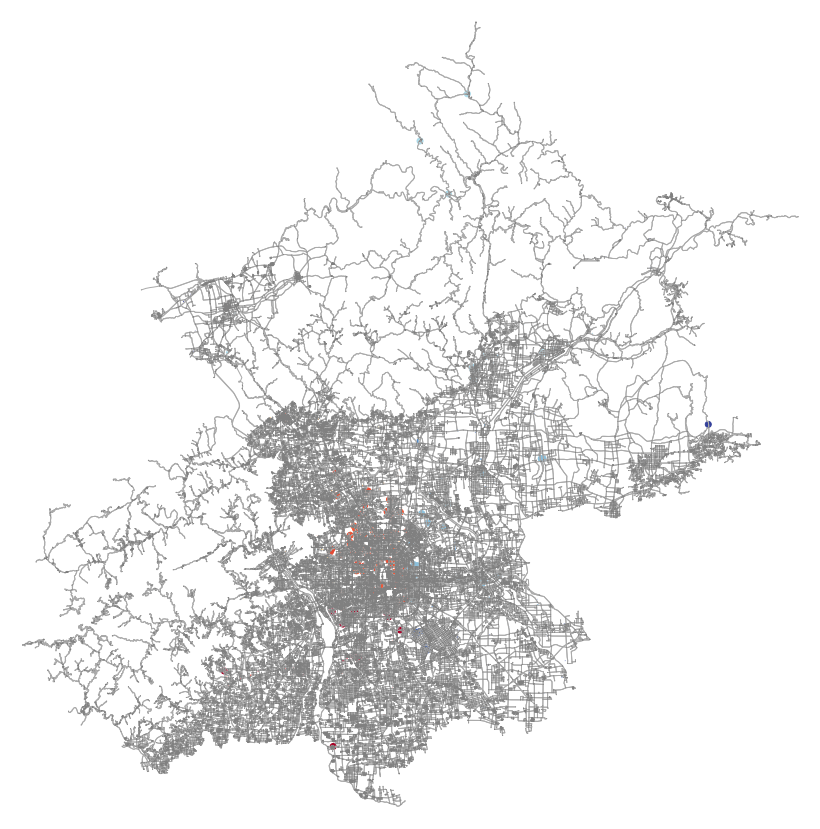

2022-05-15 14:21:29 Finished plotting the graph


In [42]:
ax = all_schools.plot(cmap="RdYlBu", figsize=(15,15), legend=True)
ax = ox.plot_graph(G, ax=ax, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa")

### Find the center of the school

In [37]:
print(all_schools['geometry'].bounds)

# This adds one more column named "center" to all_schools
all_schools['center'] = gpd.points_from_xy(x= all_schools['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_schools['geometry'].bounds[['miny','maxy']].mean(axis=1))
print(all_schools['center'])
print(all_schools.keys())

# Check an example
print('-'*50)
HKMS = all_schools.iloc[5]
print(HKMS['name'])
print(HKMS['center'])

                               minx       miny        maxx       maxy
element_type osmid                                                   
node         3387681985  113.554298  22.161612  113.554298  22.161612
             3536413546  113.554617  22.206436  113.554617  22.206436
             4581533888  113.543617  22.210628  113.543617  22.210628
             4752650816  113.542002  22.193218  113.542002  22.193218
way          172300546   113.551653  22.202197  113.553003  22.203749
...                             ...        ...         ...        ...
             681033240   113.550159  22.114491  113.550718  22.115205
             681624148   113.551177  22.160132  113.551715  22.160630
             824733409   113.547563  22.209394  113.548367  22.210208
relation     3598313     113.548885  22.197822  113.549616  22.198550
             10228816    113.559501  22.204765  113.559894  22.205184

[67 rows x 4 columns]
element_type  osmid     
node          3387681985    POINT (113.554

## Task (1): Travelling Salesman Problem (TSP) using NetworkX (20%)

Given a set of requests (e.g., 20 building locations) and a school location, your task is to design the route based on the Travelling Salesman Problem (https://en.wikipedia.org/wiki/Travelling_salesman_problem).

In order to test the routing performance, in this assignment, we **force** you to use **the nearest neighbor algorithm (a greedy algorithm)**, which lets the salesman choose the nearest request as his next move.

For the routing algorihtm, please use **NetworkX** in Task (1)
https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html

In [38]:
def extract_graph(place='Macau'):
    ox.config(log_console=True, use_cache=True)
    G = ox.graph_from_place(place, network_type='drive')
    return G
    
def extract_schools_buildings(place='Macau'):
    ox.config(log_console=True, use_cache=True)
    tags = {'building': ['residential']}
    all_buildings = ox.geometries_from_place(place, tags=tags)
    #we only interested in building names and it's geometric information
    all_buildings = all_buildings[['name','geometry']]
    all_buildings = all_buildings[~(all_buildings['name'].isnull())]
    all_buildings = all_buildings[~(all_buildings['geometry'].isnull())]
    all_buildings['center'] = gpd.points_from_xy(x= all_buildings['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_buildings['geometry'].bounds[['miny','maxy']].mean(axis=1))
    
    tags = {'amenity': ['school']}
    all_schools = ox.geometries_from_place(place, tags=tags)
    all_schools = all_schools[~(all_schools['name'].isnull())]
    all_schools = all_schools[~(all_schools['geometry'].isnull())]
    all_schools['center'] = gpd.points_from_xy(x= all_schools['geometry'].bounds[['minx','maxx']].mean(axis=1),y=all_schools['geometry'].bounds[['miny','maxy']].mean(axis=1))
    return all_schools,all_buildings

def generate_case(all_schools,all_buildings,n=20):
    school = all_schools.sample(1).iloc[0]
    node_school  = ox.distance.nearest_nodes(G,X=school['center'].x,Y = school['center'].y)
    buildings = all_buildings.sample(1)
    while True:
        tmp = buildings.iloc[-1]
        node_building = ox.distance.nearest_nodes(G,X = tmp['center'].x,Y = tmp['center'].y)
        if not (nx.has_path(G,node_school,node_building) and nx.has_path(G,node_building,node_school)):
            buildings.drop(buildings.tail(1).index,inplace=True)
        if len(buildings)>=n:
            break
        buildings = pd.concat([buildings,all_buildings.sample(1)])
    
    return school, buildings



In [169]:
#Test case
G = extract_graph('Macau')
all_schools,all_buildings = extract_schools_buildings('Macau')

# Randomly get 20 buildings and a school
school, buildings = generate_case(all_schools,all_buildings,20)
print(buildings["name"])

2022-04-11 22:10:52 Configured OSMnx 1.1.2
2022-04-11 22:10:52 HTTP response caching is on
2022-04-11 22:10:52 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-04-11 22:10:52 Created GeoDataFrame with 1 rows from 1 queries
2022-04-11 22:10:52 Constructed place geometry polygon(s) to query API
2022-04-11 22:10:52 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-04-11 22:10:52 Projected GeoDataFrame to epsg:4326
2022-04-11 22:10:52 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-04-11 22:10:52 Projected GeoDataFrame to epsg:4326
2022-04-11 22:10:52 Requesting data within polygon from API in 1 request(s)
2022-04-11 22:10:52 Retrieved response from cache file "cache/ff1a5990518c10847f02b7fc0c6b9d23095a8162.json"
2022-04-11 22:10:52 Got all network data within polygon from API in 1 request(s)
2022-04-11 22:10:52 Creating graph from downl

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-04-11 22:10:52 Created graph with 23437 nodes and 29498 edges
2022-04-11 22:10:52 Added length attributes to graph edges
2022-04-11 22:10:52 Identifying all nodes that lie outside the polygon...
2022-04-11 22:10:53 Created nodes GeoDataFrame from graph
2022-04-11 22:10:53 Created r-tree spatial index for 23437 geometries
2022-04-11 22:10:53 Identified 22759 geometries inside polygon
2022-04-11 22:10:53 Removed 678 nodes outside polygon
2022-04-11 22:10:53 Truncated graph by polygon
2022-04-11 22:10:53 Begin topologically simplifying the graph...
2022-04-11 22:10:53 Identified 3456 edge endpoints
2022-04-11 22:10:54 Found 2 edges between 6219106949 and 4208824304 when simplifying
2022-04-11 22:10:54 Found 2 edges between 4208824304 and 4208824307 when simplifying
2022-04-11 22:10:54 Found 2 edges between 1832146625 and 1939314730 when simplifying
2022-04-11 22:10:54 Found 2 edges between 1939314730 and 1832146673 when simplifying
2022-04-11 22:10:54 Found 2 edges between 1832146673

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-04-11 22:10:55 0 geometries removed by the polygon filter
2022-04-11 22:10:55 38 geometries removed by the tag filter
2022-04-11 22:10:55 70 geometries in the final GeoDataFrame
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-04-11 22:10:55 Created nodes GeoDataFrame from graph
2022-

In [216]:
# Your solution here
def TSP_NX(G,school,buildings,print_msg=True):
    # Get graph nodes for school and buildings, namely coords -> nodes
    node_school  = ox.distance.nearest_nodes(G,X=school['center'].x,Y = school['center'].y)
    nodes_buildings = ox.distance.nearest_nodes(G,X = buildings['center'].x,Y = buildings['center'].y)
    
    # For output the name of path
    node_name = {} #mapping of node to building name
    node_name[node_school] = school['name']
    for i in range(len(nodes_buildings)):
        node_name[nodes_buildings[i]] = buildings.iloc[i]['name']

    # init
    p = node_school
    if print_msg:
        print(node_name[p],end='')
    travel_path = []
    residual_nodes_buildings = nodes_buildings.copy()
    total_distance = 0

    # TSP - Implement the Ｎearest Ｎeighbor based TSP　algorithm
    # use NetworkX to find the shortest path
    # *************** your code begin ***************
    visited = set()
    while True:
        sp, sp_nxt, sp_length = None, None, 1e31
        for nxt in nodes_buildings:
            if nxt == p or nxt in visited:
                continue
            path = nx.shortest_path(G,source=p,target=nxt,method='dijkstra',weight='length')
            path_length = nx.path_weight(G, path, weight='length')
            if path_length < sp_length:
                sp, sp_nxt, sp_length = path, nxt, path_length
        if sp_nxt == None:
            path = nx.shortest_path(G,source=p,target=node_school,method='dijkstra',weight='length')
            travel_path.append(path)
            total_distance += nx.path_weight(G, path, weight='length')
            break
        else:
            total_distance += sp_length
            p = sp_nxt
            visited.add(sp_nxt)
            travel_path.append(sp)

    # *************** your code end ***************
    return travel_path


In [217]:
tik = time()
travel_path = TSP_NX(G, school, buildings)
tok = time()
print('Compute Time: %fs'%(tok-tik))

2022-04-11 22:28:02 Created nodes GeoDataFrame from graph
2022-04-11 22:28:02 Created nodes GeoDataFrame from graph
慈幼中學 Instituto SalesianoCompute Time: 0.511217s


### Plotting the map and the result route

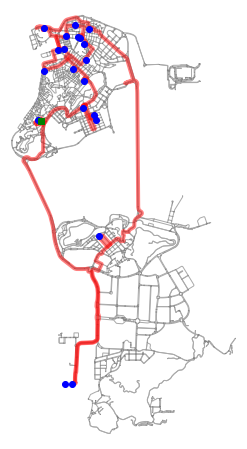

In [218]:
fig , ax = ox.plot_graph(G, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
ax.scatter(school['center'].x,school['center'].y,c='g',marker="s",alpha=1,zorder=4)
ax.scatter(buildings['center'].x,buildings['center'].y,c='blue',alpha=1,zorder=3)

for path in travel_path:
    clear_output(wait = True)
    ox.plot_graph_route(G,path,ax=ax,orig_dest_size=0,route_alpha=0.5,route_colors='r',route_linewidths=2,show=False,close=False); 
    plt.pause(0.1)
    display(fig)

## Task (2): Travelling Salesman Problem (TSP) using Pandana (20%)

The task is the same as Task (1) but you replace the routing algorithm by CH.

For the routing algorihtm, please use **Pandana** in Task (2)
https://udst.github.io/pandana/

In [219]:
# Your solution here
def TSP_Pandana(G_pan,school,buildings,print_msg=True):
    # Find nearest node in graph
    node_school  = G_pan.get_node_ids([school['center'].x],[school['center'].y]).iloc[0] # x,y in pandana must be pandas.series
    nodes_buildings = list(G_pan.get_node_ids(buildings['center'].x,buildings['center'].y))

    # For output the name of path
    node_name = {} #mapping of node to building name
    node_name[node_school] = school['name']
    for i in range(len(nodes_buildings)):
        node_name[nodes_buildings[i]] = buildings.iloc[i]['name']
        
    # Init
    p = node_school
    if print_msg:
        print(node_name[p],end='')
    travel_path = []
    residual_nodes_buildings = nodes_buildings.copy()
    total_distance = 0
    
    # TSP - Implement the Ｎearest Ｎeighbor based TSP　algorithm
    # use Pandana to find the shortest path
    # *************** your code begin ***************
    visited = set()
    while True:
        sp, sp_nxt, sp_length = None, None, 1e31
        for nxt in nodes_buildings:
            if nxt == p or nxt in visited:
                continue
            path = list(G_pan.shortest_path(p,nxt))
            path_length = G_pan.shortest_path_length(p,nxt)
            if path_length < sp_length:
                sp, sp_nxt, sp_length = path, nxt, path_length
        if sp_nxt == None:
            path = list(G_pan.shortest_path(p, node_school))
            travel_path.append(path)
            total_distance += G_pan.shortest_path_length(p, node_school)
            break
        else:
            total_distance += sp_length
            p = sp_nxt
            visited.add(sp_nxt)
            travel_path.append(sp)

    # *************** your code end ***************
    return travel_path



In [220]:
nodes,edges = ox.graph_to_gdfs(G,nodes=True,edges=True)
edges = edges.reset_index()
G_pan = pandana.Network(nodes['x'], nodes['y'], edges['u'], edges['v'], edges[['length']],twoway=False)
tik = time()
travel_path = TSP_Pandana(G_pan,school,buildings)
tok = time()
print('Compute Time: %fs'%(tok-tik))

2022-04-11 22:28:30 Created nodes GeoDataFrame from graph
2022-04-11 22:28:30 Created edges GeoDataFrame from graph
Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 3034
Setting CH edge vector of size 5324
Range graph removed 1400 edges of 10648
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
慈幼中學 Instituto SalesianoCompute Time: 0.276067s


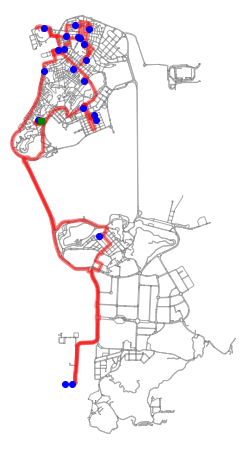

In [221]:
fig , ax = ox.plot_graph(G, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
ax.scatter(school['center'].x,school['center'].y,c='g',marker="s",alpha=1,zorder=4)
ax.scatter(buildings['center'].x,buildings['center'].y,c='blue',alpha=1,zorder=3)

for path in travel_path:
    clear_output(wait = True)
    ox.plot_graph_route(G,path,ax=ax,orig_dest_size=0,route_alpha=0.5,route_colors='r',route_linewidths=2,show=False,close=False); 
    plt.pause(0.1)
    display(fig)

## Task (3): Compare the performance (20%)

Please test the scalability of your solution in task (1) and (2) by enlarging the number of requests to (10, 20, 40, 80, ...) and change the city from Macau to a larger city (e.g., Beijing). Report the running time of both solutions.

In [222]:
#Test case
place = 'Beijing'
G = extract_graph(place)

nodes,edges = ox.graph_to_gdfs(G,nodes=True,edges=True)
edges = edges.reset_index()
G_pan = pandana.Network(nodes['x'], nodes['y'], edges['u'], edges['v'], edges[['length']],twoway=False)

all_schools,all_buildings = extract_schools_buildings(place)

time_NX = []
time_Pandana = []
n_case = range(10,101,10)

# making use the following functions to compute the response time of different cases

# *************** your code begin ***************
for i in n_case:
    print(f"Number od buildings: {i}")
    school,buildings = generate_case(all_schools,all_buildings,i)

    tik = time()
    TSP_NX(G,school,buildings,print_msg=False)
    tok = time()
    # record the time into **time_NX**
    time_NX.append(tok - tik)
    print(f"NX: {tok - tik}")

    tik = time()
    TSP_Pandana(G_pan,school,buildings,print_msg=False)
    tok = time()
    # record the time into **time_Pandana**
    time_Pandana.append(tok - tik)
    print(f"Pandana: {tok - tik}")

# *************** your code end ***************

2022-04-11 22:28:40 Configured OSMnx 1.1.2
2022-04-11 22:28:40 HTTP response caching is on
2022-04-11 22:28:40 Retrieved response from cache file "cache/17c5f7fabc9b55ff8640592391a53a7511dbb2a0.json"
2022-04-11 22:28:40 Created GeoDataFrame with 1 rows from 1 queries
2022-04-11 22:28:40 Constructed place geometry polygon(s) to query API
2022-04-11 22:28:40 Projected GeoDataFrame to +proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-04-11 22:28:40 Projected GeoDataFrame to epsg:4326
2022-04-11 22:28:40 Projected GeoDataFrame to +proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-04-11 22:28:40 Projected GeoDataFrame to epsg:4326
2022-04-11 22:28:40 Requesting data within polygon from API in 16 request(s)
2022-04-11 22:28:40 Retrieved response from cache file "cache/b6f979acb35b5158e0794462dbb962ec5604506f.json"


/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-04-11 22:28:40 Retrieved response from cache file "cache/5f96a2c4a1ac150041d6db1e7474874872bb3df8.json"
2022-04-11 22:28:40 Retrieved response from cache file "cache/cc72abc220e4dca8d34a4a2fbd0710e1192a9929.json"
2022-04-11 22:28:40 Retrieved response from cache file "cache/79272128f88b58bb003d8f511b8173ca0f6835fc.json"
2022-04-11 22:28:40 Retrieved response from cache file "cache/e66e0ee70886b018b811918ea4413ef087476989.json"
2022-04-11 22:28:40 Retrieved response from cache file "cache/3831cc95610de1dcd79ffa6ba32a758882608776.json"
2022-04-11 22:28:41 Retrieved response from cache file "cache/cab7478ec15ed8f395990e1dfdb53b18e6a938dd.json"
2022-04-11 22:28:41 Retrieved response from cache file "cache/cb1feaba5c97e97b02012b85e5993fca546d9737.json"
2022-04-11 22:28:41 Retrieved response from cache file "cache/ac4369638a7c016657a5934500a248444b7a2bd5.json"
2022-04-11 22:28:41 Retrieved response from cache file "cache/48e14dfa5165bae206f39492f5b772a47ea16d63.json"
2022-04-11 22:28:41

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-04-11 22:30:44 Created r-tree spatial index for 4633 geometries
2022-04-11 22:30:45 Identified 4610 geometries inside polygon
2022-04-11 22:30:45 23 geometries removed by the polygon filter
2022-04-11 22:30:45 36 geometries removed by the tag filter
2022-04-11 22:30:45 4574 geometries in the final GeoDataFrame
2022-04-11 22:30:45 Retrieved response from cache file "cache/17c5f7fabc9b55ff8640592391a53a7511dbb2a0.json"
2022-04-11 22:30:45 Created GeoDataFrame with 1 rows from 1 queries
2022-04-11 22:30:45 Constructed place geometry polygon(s) to query API
2022-04-11 22:30:45 Projected GeoDataFrame to +proj=utm +zone=50 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-04-11 22:30:45 Projected GeoDataFrame to epsg:4326
2022-04-11 22:30:45 Requesting data within polygon from API in 16 request(s)
2022-04-11 22:30:45 Retrieved response from cache file "cache/2e18a25c15f33f23a1801ce95b55c46bcf563350.json"
2022-04-11 22:30:45 Retrieved response from cache file "cache/2f9b9a71c9d4

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestring

2022-04-11 22:30:45 1895 geometries created in the dict
2022-04-11 22:30:45 19 untagged geometries removed
2022-04-11 22:30:45 Created r-tree spatial index for 1876 geometries
2022-04-11 22:30:46 Identified 1778 geometries inside polygon
2022-04-11 22:30:46 98 geometries removed by the polygon filter
2022-04-11 22:30:46 79 geometries removed by the tag filter
2022-04-11 22:30:46 1700 geometries in the final GeoDataFrame
Number od buildings: 10
2022-04-11 22:30:47 Created nodes GeoDataFrame from graph
2022-04-11 22:30:47 Created nodes GeoDataFrame from graph
2022-04-11 22:30:48 Created nodes GeoDataFrame from graph
2022-04-11 22:30:48 Created nodes GeoDataFrame from graph
2022-04-11 22:30:48 Created nodes GeoDataFrame from graph
2022-04-11 22:30:49 Created nodes GeoDataFrame from graph
2022-04-11 22:30:49 Created nodes GeoDataFrame from graph
2022-04-11 22:30:49 Created nodes GeoDataFrame from graph
2022-04-11 22:30:50 Created nodes GeoDataFrame from graph
2022-04-11 22:30:50 Created no

2022-04-11 22:33:31 Created nodes GeoDataFrame from graph
2022-04-11 22:33:32 Created nodes GeoDataFrame from graph
2022-04-11 22:33:32 Created nodes GeoDataFrame from graph
2022-04-11 22:33:33 Created nodes GeoDataFrame from graph
2022-04-11 22:33:33 Created nodes GeoDataFrame from graph
2022-04-11 22:33:33 Created nodes GeoDataFrame from graph
2022-04-11 22:33:34 Created nodes GeoDataFrame from graph
2022-04-11 22:33:34 Created nodes GeoDataFrame from graph
2022-04-11 22:33:34 Created nodes GeoDataFrame from graph
2022-04-11 22:33:35 Created nodes GeoDataFrame from graph
2022-04-11 22:33:35 Created nodes GeoDataFrame from graph
2022-04-11 22:33:35 Created nodes GeoDataFrame from graph
2022-04-11 22:33:36 Created nodes GeoDataFrame from graph
2022-04-11 22:33:36 Created nodes GeoDataFrame from graph
2022-04-11 22:33:36 Created nodes GeoDataFrame from graph
2022-04-11 22:33:37 Created nodes GeoDataFrame from graph
2022-04-11 22:33:37 Created nodes GeoDataFrame from graph
2022-04-11 22:

2022-04-11 22:38:25 Created nodes GeoDataFrame from graph
2022-04-11 22:38:26 Created nodes GeoDataFrame from graph
2022-04-11 22:38:26 Created nodes GeoDataFrame from graph
2022-04-11 22:38:26 Created nodes GeoDataFrame from graph
2022-04-11 22:38:26 Created nodes GeoDataFrame from graph
2022-04-11 22:38:27 Created nodes GeoDataFrame from graph
2022-04-11 22:38:27 Created nodes GeoDataFrame from graph
2022-04-11 22:38:27 Created nodes GeoDataFrame from graph
2022-04-11 22:38:28 Created nodes GeoDataFrame from graph
2022-04-11 22:38:28 Created nodes GeoDataFrame from graph
2022-04-11 22:38:29 Created nodes GeoDataFrame from graph
2022-04-11 22:38:29 Created nodes GeoDataFrame from graph
2022-04-11 22:38:30 Created nodes GeoDataFrame from graph
2022-04-11 22:38:30 Created nodes GeoDataFrame from graph
2022-04-11 22:38:30 Created nodes GeoDataFrame from graph
2022-04-11 22:38:31 Created nodes GeoDataFrame from graph
2022-04-11 22:38:31 Created nodes GeoDataFrame from graph
2022-04-11 22:

2022-04-11 22:47:46 Created nodes GeoDataFrame from graph
2022-04-11 22:47:46 Created nodes GeoDataFrame from graph
2022-04-11 22:47:47 Created nodes GeoDataFrame from graph
2022-04-11 22:47:47 Created nodes GeoDataFrame from graph
2022-04-11 22:47:47 Created nodes GeoDataFrame from graph
2022-04-11 22:47:48 Created nodes GeoDataFrame from graph
2022-04-11 22:47:48 Created nodes GeoDataFrame from graph
2022-04-11 22:47:48 Created nodes GeoDataFrame from graph
2022-04-11 22:47:49 Created nodes GeoDataFrame from graph
2022-04-11 22:47:49 Created nodes GeoDataFrame from graph
2022-04-11 22:47:49 Created nodes GeoDataFrame from graph
2022-04-11 22:47:50 Created nodes GeoDataFrame from graph
2022-04-11 22:47:50 Created nodes GeoDataFrame from graph
2022-04-11 22:47:50 Created nodes GeoDataFrame from graph
2022-04-11 22:47:51 Created nodes GeoDataFrame from graph
2022-04-11 22:47:51 Created nodes GeoDataFrame from graph
2022-04-11 22:47:51 Created nodes GeoDataFrame from graph
2022-04-11 22:

2022-04-11 22:53:36 Created nodes GeoDataFrame from graph
2022-04-11 22:53:36 Created nodes GeoDataFrame from graph
2022-04-11 22:53:37 Created nodes GeoDataFrame from graph
2022-04-11 22:53:37 Created nodes GeoDataFrame from graph
2022-04-11 22:53:37 Created nodes GeoDataFrame from graph
2022-04-11 22:53:38 Created nodes GeoDataFrame from graph
2022-04-11 22:53:38 Created nodes GeoDataFrame from graph
2022-04-11 22:53:38 Created nodes GeoDataFrame from graph
2022-04-11 22:53:39 Created nodes GeoDataFrame from graph
2022-04-11 22:53:39 Created nodes GeoDataFrame from graph
2022-04-11 22:53:40 Created nodes GeoDataFrame from graph
2022-04-11 22:53:40 Created nodes GeoDataFrame from graph
2022-04-11 22:53:40 Created nodes GeoDataFrame from graph
2022-04-11 22:53:41 Created nodes GeoDataFrame from graph
2022-04-11 22:53:41 Created nodes GeoDataFrame from graph
2022-04-11 22:53:41 Created nodes GeoDataFrame from graph
2022-04-11 22:53:42 Created nodes GeoDataFrame from graph
2022-04-11 22:

### Plotting the result chart using Matplotlib

/tmp/ipykernel_7523/988204208.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


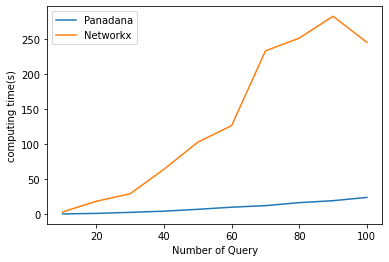

In [223]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
clear_output(wait = True)
ax.plot(n_case,time_Pandana,label='Panadana')
ax.plot(n_case,time_NX,label='Networkx')
plt.ylabel('computing time(s)')
plt.xlabel('Number of Query')
plt.legend()
fig.show()

## Task (4): Design a better solution (40%)

Besides replacing the TSP algorithm, do you have any suggestion to improve the scalability of the solution? The solution could be an idea in terms of data strucutres, algorithms, and / or real world settings. Please discuss the reason why the idea could improve the overall scalability.

**Hints:** does it make sense to pick up every kid at their requested buildings?

We will evaluate your answer by 
1) The soundness of your idea
2) The technical novelty of your idea
3) The quality of analysis
4) Implementation (if any)

### 4(A) Your written answer
It incurs a lot of overhead to pick up everybody at specified buildings since the pick-up can only be serialized (one-by-one). Therefore, setting up some pick-up spots would be a better solution than naive TSP, since taking a walk for everybody from his building to the nearest pick-up point could be concurrent, which overlaps the total latency. 

In detail, we could first choose some pick-up points according to the original buildings but much less than them, say one-fifth in amount. Then we could conduct TSP on these pick-up points.  

A K-Means clustering algorithm could be used to choose pick-up points.

### 4(B) Your implementation (if any)

In [224]:
### your code
from sklearn.cluster import KMeans

def get_pick_up_points(buildings):
    building_coords = []
    for building in buildings.iloc:
        building_coords.append([building['center'].x, building['center'].y])

    coords = np.array(building_coords)
    kmeans = KMeans(n_clusters=len(buildings)//3)
    # Simply use euclidean distances to cluster here, better use graph weights.
    kmeans.fit(coords)

    return kmeans.cluster_centers_

def My_TSP_NX(G, school, pick_up_points):
    node_school  = ox.distance.nearest_nodes(G,X=school['center'].x,Y = school['center'].y)
    nodes_pick_up = ox.distance.nearest_nodes(G,X = pick_up_points[:, 0],Y = pick_up_points[:, 1])

    p = node_school
    travel_path = []
    total_distance = 0
    
    visited = set()
    while True:
        sp, sp_nxt, sp_length = None, None, 1e31
        for nxt in nodes_pick_up:
            if nxt == p or nxt in visited:
                continue
            path = nx.shortest_path(G,source=p,target=nxt,method='dijkstra',weight='length')
            path_length = nx.path_weight(G, path, weight='length')
            if path_length < sp_length:
                sp, sp_nxt, sp_length = path, nxt, path_length
        if sp_nxt == None:
            path = nx.shortest_path(G,source=p,target=node_school,method='dijkstra',weight='length')
            travel_path.append(path)
            total_distance += nx.path_weight(G, path, weight='length')
            break
        else:
            total_distance += sp_length
            p = sp_nxt
            visited.add(sp_nxt)
            travel_path.append(sp)

    return travel_path

In [225]:
# Test case
G = extract_graph('Macau')
all_schools, all_buildings = extract_schools_buildings('Macau')

# Randomly get 50 buildings and a school
school, buildings = generate_case(all_schools, all_buildings, 50)

2022-04-11 22:58:16 Configured OSMnx 1.1.2
2022-04-11 22:58:16 HTTP response caching is on
2022-04-11 22:58:17 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-04-11 22:58:17 Created GeoDataFrame with 1 rows from 1 queries
2022-04-11 22:58:17 Constructed place geometry polygon(s) to query API
2022-04-11 22:58:17 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-04-11 22:58:17 Projected GeoDataFrame to epsg:4326
2022-04-11 22:58:17 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-04-11 22:58:17 Projected GeoDataFrame to epsg:4326
2022-04-11 22:58:17 Requesting data within polygon from API in 1 request(s)
2022-04-11 22:58:17 Retrieved response from cache file "cache/ff1a5990518c10847f02b7fc0c6b9d23095a8162.json"
2022-04-11 22:58:17 Got all network data within polygon from API in 1 request(s)
2022-04-11 22:58:17 Creating graph from downl

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-04-11 22:58:17 Added length attributes to graph edges
2022-04-11 22:58:17 Identifying all nodes that lie outside the polygon...
2022-04-11 22:58:17 Created nodes GeoDataFrame from graph
2022-04-11 22:58:18 Created r-tree spatial index for 23437 geometries
2022-04-11 22:58:18 Identified 22759 geometries inside polygon
2022-04-11 22:58:18 Removed 678 nodes outside polygon
2022-04-11 22:58:18 Truncated graph by polygon
2022-04-11 22:58:18 Begin topologically simplifying the graph...
2022-04-11 22:58:18 Identified 3456 edge endpoints
2022-04-11 22:58:18 Found 2 edges between 6219106949 and 4208824304 when simplifying
2022-04-11 22:58:18 Found 2 edges between 4208824304 and 4208824307 when simplifying
2022-04-11 22:58:18 Found 2 edges between 1832146625 and 1939314730 when simplifying
2022-04-11 22:58:18 Found 2 edges between 1939314730 and 1832146673 when simplifying
2022-04-11 22:58:18 Found 2 edges between 1832146673 and 3124347714 when simplifying
2022-04-11 22:58:18 Found 2 edges 

/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/usr/local/miniconda3/envs/geospatial/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2022-04-11 22:58:19 Retrieved response from cache file "cache/7302b1a1a554970a7aae66a37ab1d3a125087b11.json"
2022-04-11 22:58:19 Created GeoDataFrame with 1 rows from 1 queries
2022-04-11 22:58:19 Constructed place geometry polygon(s) to query API
2022-04-11 22:58:19 Projected GeoDataFrame to +proj=utm +zone=49 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-04-11 22:58:19 Projected GeoDataFrame to epsg:4326
2022-04-11 22:58:19 Requesting data within polygon from API in 1 request(s)
2022-04-11 22:58:19 Retrieved response from cache file "cache/a32cc7199e90a1ace4eee360d5e0af17423ed8cb.json"
2022-04-11 22:58:19 Got all geometries data within polygon from API in 1 request(s)
2022-04-11 22:58:19 Converting 912 elements in JSON responses to geometries
2022-04-11 22:58:19 114 geometries created in the dict
2022-04-11 22:58:19 6 untagged geometries removed
2022-04-11 22:58:19 Created r-tree spatial index for 108 geometries
2022-04-11 22:58:19 Identified 108 geometries inside polygo

In [226]:
# Profile and compare
tik = time()
travel_path_1 = TSP_NX(G, school, buildings)
tok = time()
print('Compute Time for original TSP: %fs'%(tok-tik))

tik = time()
# Get pick-up points
pick_up_ponits = get_pick_up_points(buildings)
travel_path_2 = My_TSP_NX(G, school, pick_up_ponits)
tok = time()
print('Compute Time for pick-up points TSP: %fs'%(tok-tik))

2022-04-11 22:58:20 Created nodes GeoDataFrame from graph
2022-04-11 22:58:20 Created nodes GeoDataFrame from graph
航海學校 Escola de PilotagemCompute Time for original TSP: 2.612400s
2022-04-11 22:58:23 Created nodes GeoDataFrame from graph
2022-04-11 22:58:23 Created nodes GeoDataFrame from graph
Compute Time for pick-up points TSP: 0.740881s


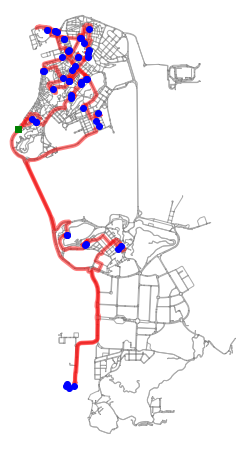

In [227]:
# Draw result 1
fig , ax = ox.plot_graph(G, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
ax.scatter(school['center'].x,school['center'].y,c='g',marker="s",alpha=1,zorder=4)
ax.scatter(buildings['center'].x,buildings['center'].y,c='blue',alpha=1,zorder=3)

for path in travel_path_1:
    clear_output(wait = True)
    ox.plot_graph_route(G,path,ax=ax,orig_dest_size=0,route_alpha=0.5,route_colors='r',route_linewidths=2,show=False,close=False); 
    plt.pause(0.1)
    display(fig) 

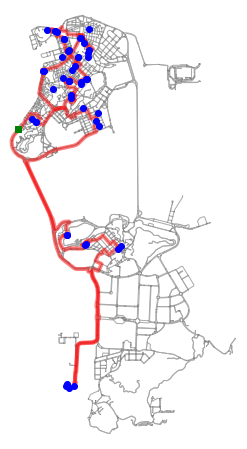

In [228]:
# Draw result 2
fig , ax = ox.plot_graph(G, bgcolor="w", node_size=1, node_color="gray", edge_color="#aaa",show=False,close=False)
ax.scatter(school['center'].x,school['center'].y,c='g',marker="s",alpha=1,zorder=4)
ax.scatter(buildings['center'].x,buildings['center'].y,c='blue',alpha=1,zorder=3)

for path in travel_path_2:
    clear_output(wait = True)
    ox.plot_graph_route(G,path,ax=ax,orig_dest_size=0,route_alpha=0.5,route_colors='r',route_linewidths=2,show=False,close=False); 
    plt.pause(0.1)
    display(fig) 